<a href="https://colab.research.google.com/github/bmijangos/ProyectoIntegrador/blob/main/Avance3_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 3
## Baseline
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
19 de mayo de 2024

### Importaciones, Funciones, Dependencias y Pasos Iniciales

In [22]:
!pip install --upgrade nbformat nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


In [23]:
!pip uninstall -y nbformat nbconvert


Found existing installation: nbformat 5.10.4
Uninstalling nbformat-5.10.4:
  Successfully uninstalled nbformat-5.10.4
Found existing installation: nbconvert 7.16.4
Uninstalling nbconvert-7.16.4:
  Successfully uninstalled nbconvert-7.16.4


In [24]:
!pip install nbformat nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.4 MB/s eta 0:00:00
  Using cached nbconvert-7.16.4-py3-none-any.whl (257 kB)


In [25]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:

!pip install feature_engine


In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.outliers import OutlierTrimmer

#Las siguientes librerías son los modelos que voy a entrenar y el método de validación cruzada k-fold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree  # para el grafico de arbol de decision
from IPython.display import Image

import scipy.cluster.hierarchy as sch   # requerimos el módulo referente a la agrupamiento jerárquico.
from sklearn.cluster import AgglomerativeClustering    # usaremos la técnica de agrupamiento llamada aglomerativa


In [28]:
# función para mostrar un diagrama de caja encima de un histograma
def plot_boxplot_hist(data, variable):
  f,(ax_box, ax_hist) = plt.subplots(2,
                                     sharex=True,
                                     gridspec_kw={"height_ratios":(0.50,0.85)})
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data, x=variable, ax=ax_hist)
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()


In [29]:
# función para encontrar los límites de una distribución variable usando la regla de proximidad del rango intercuartil:

def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR * fold)
  upper_limit = df[variable].quantile(0.75)+(IQR * fold)
  return lower_limit, upper_limit

In [30]:
def get_models():

    models = list()
    names = list()

    # LR - Regresión Logística:
    models.append(LogisticRegression(solver='liblinear'))
    names.append('Logistic Regression')

    # DT - Árbol de Decisión:
    models.append(DecisionTreeClassifier())
    names.append('Decision Tree')

    # RFC - Random forest classifier
    models.append(RandomForestClassifier())
    names.append('Random Forest Classifier')

    return models, names

In [31]:
def mi_accuracy (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_accuracy = (VP + VN) / (VP + VN + FP + FN)
  return mi_accuracy

def mi_precision (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_precision = VP / (VP + FP)
  return mi_precision

def mi_recall (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_recall = VP / (VP + FN)
  return mi_recall

def mi_f1_score (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_f1_score = (2*VP) / (2*VP + FP + FN)
  return mi_f1_score

def mi_G_mean (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_G_mean = np.sqrt((VP / (VP + FN))*(VN / (VN + FP)))
  return mi_G_mean

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [ ]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

In [32]:
grupal_df.isnull().sum()

IdCliente                   0
FechaAltaCliente            0
CodigoGrupo                 0
EdadCliente                 0
Genero                      0
EstadoCivil                 0
Escolaridad              1243
CapacidadPago               0
Localidad                   0
CodigoSucursal              0
CodigoASesor                0
NumeroCredito               0
CicloCliente                0
FechaDesembolso             0
FechaVencimiento            0
FechaCancelacion            0
Plazo                       0
PeriodoPago                 0
EstatusCredito              0
MontoCredito                0
CuotaNumero                 0
CuotaFechaVencimiento       0
CuotaFechaCancelacion     128
MontoCuota                  0
MontoCapital                0
SaldoCapital                0
EstatusCuota                0
DiasAtraso                128
dtype: int64

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

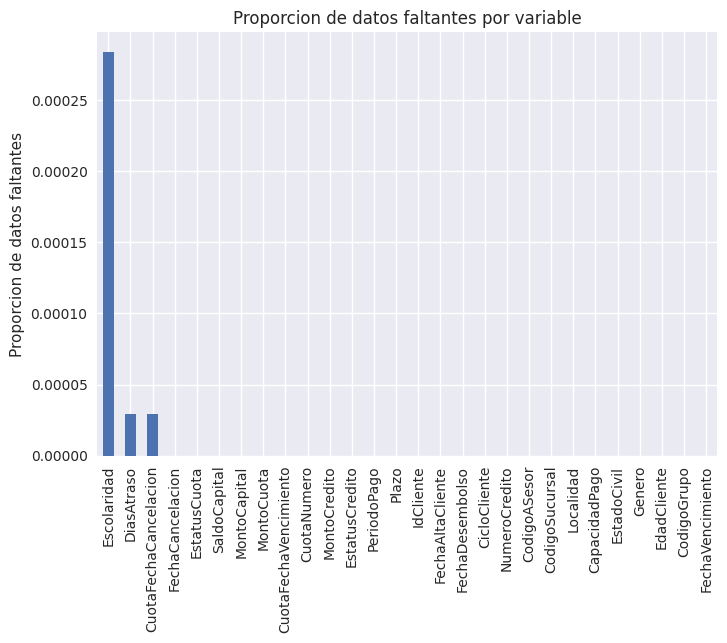

In [ ]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [ ]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [ ]:
gpdf.isnull().values.any()

False

In [ ]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

In [ ]:
gpdf.shape

(4380844, 28)

In [ ]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [ ]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [ ]:
print(gpdf.describe(include=[object]))

               FechaAltaCliente   Genero Escolaridad CodigoASesor  \
count                   4380844  4380844     4380844      4380844   
unique                    15962        2          14          528   
top     2004-02-05 00:00:00.000        F          1A       ACORZO   
freq                       7669  4378507     1302653        98613   

                FechaDesembolso         FechaVencimiento  \
count                   4380844                  4380844   
unique                     3268                     2816   
top     2013-04-30 00:00:00.000  2019-06-04 00:00:00.000   
freq                       6944                     4869   

               FechaCancelacion   PeriodoPago EstatusCredito  \
count                   4380844       4380844        4380844   
unique                     3303             3              2   
top     2015-12-08 00:00:00.000  CATORCENA(S)            CAN   
freq                       7115       3816897        4253254   

          CuotaFechaVencimiento 

In [ ]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [ ]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Se agregan los valores Maximos, la Media y la Mediana de la variable DiasAtraso por cliente y por credito

In [ ]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
gpmdadf = gpdf.groupby(['IdCliente','EdadCliente','NumeroCredito','CicloCliente','Plazo','EstadoCivil','EstatusCredito'])['DiasAtraso'].max().reset_index()

# renombramos la columna de la media
gpmdadf.rename(columns={'DiasAtraso':'DAMax'}, inplace=True)

gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 23.2+ MB


In [ ]:
# obtenemos media de los Dias de Atraso por credito
gpmeandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].mean().reset_index()

# obtenemos mediana de los Dias de Atraso por credito
gpmediandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].median().reset_index()

# renombramos la columna de la media
gpmeandf.rename(columns={'DiasAtraso':'DAMean'}, inplace=True)

# renombramos la columna de la mediana
gpmediandf.rename(columns={'DiasAtraso':'DAMedian'}, inplace=True)


In [ ]:
gpmeandf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMean         380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [ ]:
gpmediandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMedian       380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [ ]:
print(gpmdadf[gpmdadf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax  
1            CAN    0.0  
2            CAN    2.0  
3            CAN    2.0  
4            CAN  185.0  


In [ ]:
print(gpmeandf[gpmeandf['IdCliente']==6])

   IdCliente  NumeroCredito     DAMean
1          6     1000539201   0.000000
2          6     1000619301   0.333333
3          6     1000696601   0.466667
4          6     1000835501  23.400000


In [ ]:
print(gpmediandf[gpmediandf['IdCliente']==6])

   IdCliente  NumeroCredito  DAMedian
1          6     1000539201       0.0
2          6     1000619301       0.0
3          6     1000696601       0.0
4          6     1000835501       1.0


In [ ]:
# agregamos la columan de la media
newdf = pd.merge(gpmdadf, gpmeandf[['IdCliente','NumeroCredito','DAMean']], on=['IdCliente','NumeroCredito'], how='left')

# agregamos la columna de la mediana
newdf = pd.merge(newdf, gpmediandf[['IdCliente','NumeroCredito','DAMedian']], on=['IdCliente','NumeroCredito'], how='left')

In [ ]:
# mostramos los datos del cliente 6
print(newdf[newdf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax     DAMean  DAMedian  
1            CAN    0.0   0.000000       0.0  
2            CAN    2.0   0.333333       0.0  
3            CAN    2.0   0.466667       0.0  
4            CAN  185.0  23.400000       1.0  


In [ ]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
 8   DAMean          380284 non-null  float64
 9   DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 29.0+ MB


In [ ]:
newdf.head()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,EstatusCredito,DAMax,DAMean,DAMedian
0,4,65,1000353601,1,15,4,CAN,2.0,0.266667,0.0
1,6,34,1000539201,1,15,5,CAN,0.0,0.000000,0.0
2,6,34,1000619301,2,15,5,CAN,2.0,0.333333,0.0
3,6,35,1000696601,3,15,5,CAN,2.0,0.466667,0.0
4,6,36,1000835501,4,25,5,CAN,185.0,23.400000,1.0


# Algoritmo

In [ ]:
missing_data = newdf.isnull().any()
print(missing_data)
#como no existen datos faltantes NO se imputan variables de entrada

IdCliente         False
EdadCliente       False
NumeroCredito     False
CicloCliente      False
Plazo             False
EstadoCivil       False
EstatusCredito    False
DAMax             False
DAMean            False
DAMedian          False
dtype: bool


Al no existir datos faltantes, NO se imputan variables de entrada.
Pero se imputaron en la creación del pipeline para dos tipos de variables, la categórica  y la binaria.

In [ ]:

#newgpdf = gpdf[features]
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
 8   DAMean          380284 non-null  float64
 9   DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 29.0+ MB


In [ ]:
# Definir la variable objetivo y las características
X = newdf.drop('EstatusCredito', axis=1)  # Todas las columnas excepto 'EstatusCredito' son características independientes
y = newdf['EstatusCredito']  # 'EstatusCredito' es la variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones del conjunto de entrenamiento (X):", X_train.shape)
print("Dimensiones del conjunto de prueba (X):", X_test.shape)
print("Dimensiones del conjunto de entrenamiento (y):", y_train.shape)
print("Dimensiones del conjunto de prueba (y):", y_test.shape)


Dimensiones del conjunto de entrenamiento (X): (304227, 9)
Dimensiones del conjunto de prueba (X): (76057, 9)
Dimensiones del conjunto de entrenamiento (y): (304227,)
Dimensiones del conjunto de prueba (y): (76057,)


# Características importantes

*Importancia de las características*

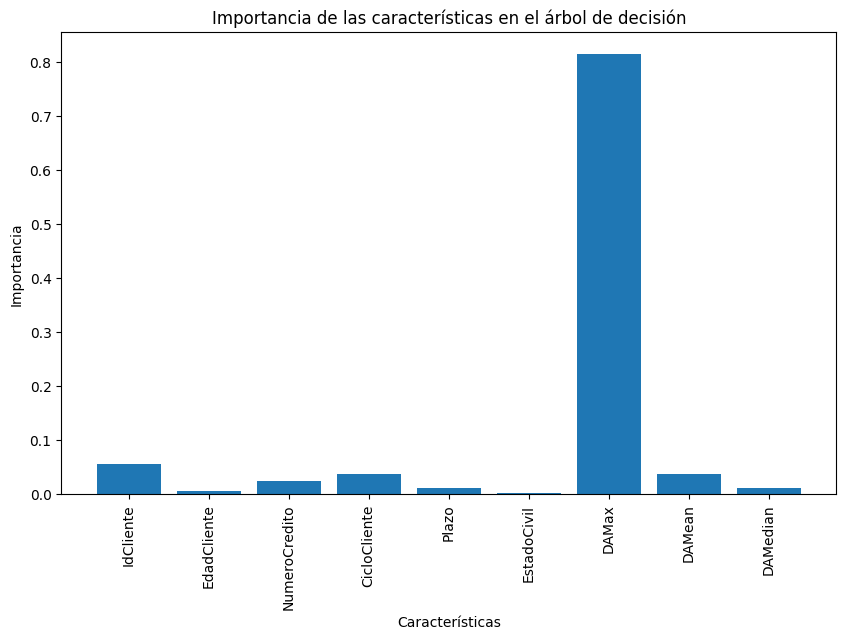

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


modelo = DecisionTreeClassifier()


modelo.fit(X_train, y_train)

# Obtener la importancia de las características
importancias_caracteristicas = modelo.feature_importances_

# Crear un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(range(len(importancias_caracteristicas)), importancias_caracteristicas)
plt.xticks(range(len(importancias_caracteristicas)), X.columns, rotation=90)
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.title('Importancia de las características en el árbol de decisión')
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import numpy as np

# Definir la función para calcular el recall
def calcular_recall(modelo, X_train, y_train, X_val, y_val):
    modelo.fit(X_train, y_train)
    y_val_pred = modelo.predict(X_val)
    return recall_score(y_val, y_val_pred, average='weighted')

# Crear el validador cruzado estratificado
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar solo el clasificador SVM
modelo = SVC()

# Almacenar los recalls para cada fold
recalls = []

# Realizar la validación cruzada
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    recall = calcular_recall(modelo, X_train, y_train, X_val, y_val)
    recalls.append(recall)

# Imprimir los recalls
print("Recalls reducidos:")
print(recalls)
print("Recall promedio:", np.mean(recalls))

Recalls reducidos:
[0.9676163929684316, 0.9676163929684316, 0.9676163929684316, 0.96760324493472, 0.9676159671820763]
Recall promedio: 0.9676136782044182


# Sub/Sobre ajuste

# Métricas

# Desempeño

# Conclusiones

